In [103]:
import autograd.numpy as np
from autograd import grad
import numpy

In [5]:
def basic(x):
    return np.dot(np.array([1.0, 2.0, 5.0, -6.0]), x * x)

grad(basic)(np.array([0, -1, 2, 0]))

array([ 0, -4, 20,  0])

In [22]:
class Simp:
    def __init__(self, param, param2):
        self.myparam = param
        self.myparam2 = param2

    def forward(self, x):
        return np.dot(x, self.myparam * self.myparam + np.cos(self.myparam2))

myclass = Simp(np.array([0, -1, 2, 0]), np.array([np.pi/2, 0, 0, 0]))

In [19]:
np.pi

3.141592653589793

In [23]:
myclass.forward(np.array([1.0, 2.0, 5.0, -6.0]))

23.0

In [28]:
def rebind(p):
    myclass.myparam = p["foo"]
    myclass.myparam2 = p["bar"]
    return myclass.forward(np.array([1.0, 2.0, 5.0, -6.0]))

grad(rebind)({ "foo": np.array([0, -1, 2, 2.5]),
               "bar": np.array([np.pi/2, 0, 0, 0]) })

{'foo': array([  0.,  -4.,  20., -30.]), 'bar': array([-1.,  0.,  0.,  0.])}

In [29]:
myclass.myparam

In [36]:
a = np.numpy_boxes.ArrayBox(value=numpy.array([1, 2, 3]))

<class 'TypeError'>: Box.__init__() missing 2 required positional arguments: 'trace' and 'node'

Some experiments on introspection

In [1]:
class Foo:
    def __init__(self, a):
        self.bar = True
        self.test = a
        self.more = [1, 2, 3]

class Baz:
    def __init__(self):
        self.hey = False
        self.nest = Foo(a = "hello")
        self.m = dict(w=45, y="ee")

obj_test1 = Baz()

In [2]:
obj_test1.__dict__

{'hey': False, 'nest': <__main__.Foo at 0x14e5bf8>, 'm': {'w': 45, 'y': 'ee'}}

In [3]:
dir(obj_test1)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'hey',
 'm',
 'nest']

In [4]:
from inspect import getmembers

getmembers(obj_test1)

[('__class__', __main__.Baz),
 ('__delattr__', <method-wrapper '__delattr__' of Baz object at 0x229e618>),
 ('__dict__',
  {'hey': False,
   'nest': <__main__.Foo at 0x14e5bf8>,
   'm': {'w': 45, 'y': 'ee'}}),
 ('__dir__', <function Baz.__dir__()>),
 ('__doc__', None),
 ('__eq__', <method-wrapper '__eq__' of Baz object at 0x229e618>),
 ('__format__', <function Baz.__format__(format_spec, /)>),
 ('__ge__', <method-wrapper '__ge__' of Baz object at 0x229e618>),
 ('__getattribute__',
  <method-wrapper '__getattribute__' of Baz object at 0x229e618>),
 ('__getstate__', <function Baz.__getstate__()>),
 ('__gt__', <method-wrapper '__gt__' of Baz object at 0x229e618>),
 ('__hash__', <method-wrapper '__hash__' of Baz object at 0x229e618>),
 ('__init__',
  <bound method Baz.__init__ of <__main__.Baz object at 0x229e618>>),
 ('__init_subclass__', <function Baz.__init_subclass__>),
 ('__le__', <method-wrapper '__le__' of Baz object at 0x229e618>),
 ('__lt__', <method-wrapper '__lt__' of Baz object

In [17]:
class ThisInherit(Baz):
    def __init__(self, c):
        #super().__init__()
        self.hey = True
        self.c = c
        self.__hidden__ = 123

obj_test2 = ThisInherit([23, 4])

In [18]:
obj_test2.__dict__

{'hey': True, 'c': [23, 4], '__hidden__': 123}

In [14]:
obj_test1.nest.__dict__

{'bar': True, 'test': 'hello', 'more': [1, 2, 3]}

## Test nn lib

In [106]:
numpy.zeros((2, 3))

array([[0., 0., 0.],
       [0., 0., 0.]])

In [124]:
#a = numpy.ones((2,3))
a += numpy.random.rand(2,3)
a

array([[ 7.90280371,  8.6283937 ,  8.23439221],
       [ 9.04852471, 10.07940354,  9.69933485]])

In [126]:
class nnParameter:
    def __init__(self, val, requires_grad=True):
        self.val = val
        self.requires_grad = requires_grad
        self.is_training = False

    @property
    def name(self):
        return self._name

    @name.setter
    def name(self, value):
        self._name = value

    def value(self):
        if self.is_training:
            return self.rebinded
        else:
            return self.val

class OptimizerSGD:
    def __init__(self, param_list, hyper_params):
        self.param_list = param_list
        self.hyper_params = hyper_params

    def steps(self):
        for param in self.param_list.values():
            param.val -= self.hyper_params["lambda"] * param.grad


In [224]:
def join_path(prefix, path):
    if len(prefix) == 0:
        return path
    else:
        return prefix + "." + path

def flatten_path_rep(prefix, lst):
    res = []
    for i, x in enumerate(lst):
        res.append((join_path(prefix, "[{i}]".format(i=i)), x))
    return res

class nnModule:
    def __init__(self):
        self._cache = 123

    def _get_attrs_filter(self, param=False, module=False, state=False):
        internal = { "_cache" }
        res = {}
        for k, v in self.__dict__.items():
            if k in internal:
                continue
            if isinstance(v, nnParameter) or \
                (isinstance(v, list) and all([isinstance(x, nnParameter) for x in v])):
                if param:
                    res[k] = v
            elif isinstance(v, nnModule) or \
                (isinstance(v, list) and all([isinstance(x, nnModule) for x in v])):
                if module:
                    res[k] = v
            elif state:
                res[k] = v
        return res
    def _get_submodules(self, prefix=""):
        result = {}
        for k, v in self._get_attrs_filter(module=True).items():
            if isinstance(v, list):
                for kp, vp in flatten_path_rep(k, v):
                    result[join_path(prefix, kp)] = vp
            else:
                result[join_path(prefix, k)] = v
        return result
    
    def get_parameters(self, nested=True, prefix=""):
        result = {}
        for k, v in self._get_attrs_filter(param=True).items():
            if isinstance(v, list):
                for kp, vp in flatten_path_rep(k, v):
                    result[join_path(prefix, kp)] = vp
            else:
                result[join_path(prefix, k)] = v
        if nested:
            submodule_params = [m.get_parameters(nested=True, prefix=path) \
                                for (path, m) in self._get_submodules().items()]
            for submodule_param in submodule_params:
                for k, v in submodule_param.items():
                    result[join_path(prefix, k)] = v
        return result

    def _set_train(self, is_training):
        for k, v in self.get_parameters(nested=True).items():
            v.name = k
            v.is_training = is_training
            #v.grad = np.zeros(v.val.shape)

    def backward(self, *inputs):
        # Hack
        self._set_train(True)
        params = self.get_parameters(nested=True)
        def rebind(ins):
            for k, v in ins.items():
                params[k].rebinded = v
            return self.forward(*inputs)
        params_cur_val = {}
        for k, v in params.items():
            params_cur_val[k] = v.val
        for k, v in grad(rebind)(params_cur_val).items():
            params[k].grad = v
        self._set_train(False)

class Dev(nnModule):
    def __init__(self, a, b, c):
        super().__init__()
        self.a = a
        self.b = b
        self.c = c

class MoreLayer(nnModule):
    def __init__(self, n):
        super().__init__()
        self.end = False
        self.sample = [nnParameter(val=i) for i in range(n)]

obj_test3 = Dev("wait", MoreLayer(2), { "foo": True, "tester": [5, 3, 1] })

In [46]:
obj_test3._get_attrs_filter(True, False, True)

{'a': 'wait', 'c': {'foo': True, 'tester': [5, 3, 1]}}

In [26]:
isinstance(obj_test3, nnModule)

True

In [48]:
obj_test4 = Dev([123, "char"], [MoreLayer(2), MoreLayer(1)], { "foo": True, "tester": [5, 3, 1] })

In [49]:
obj_test4._get_attrs_filter(True, True, False)

{'b': [<__main__.MoreLayer at 0x2905570>, <__main__.MoreLayer at 0x28b3820>]}

In [97]:
obj_test5 = Dev(nnParameter(val=[1,3]), [MoreLayer(2), MoreLayer(5)], { "foo": True, "tester": [5, 3, 1] })

In [85]:
obj_test5._get_attrs_filter(module=True)

{'b': [<__main__.MoreLayer at 0x278ff18>, <__main__.MoreLayer at 0x2858ec0>]}

In [86]:
obj_test5._get_submodules(prefix="aa")

{'aa.b.[0]': <__main__.MoreLayer at 0x278ff18>,
 'aa.b.[1]': <__main__.MoreLayer at 0x2858ec0>}

In [98]:
obj_test5.get_parameters(nested=True)

{'a': <__main__.nnParameter at 0x2274cc8>,
 'b.[0].sample.[0]': <__main__.nnParameter at 0x28beaa0>,
 'b.[0].sample.[1]': <__main__.nnParameter at 0x28beb88>,
 'b.[1].sample.[0]': <__main__.nnParameter at 0x28bf8f0>,
 'b.[1].sample.[1]': <__main__.nnParameter at 0x221c4b8>,
 'b.[1].sample.[2]': <__main__.nnParameter at 0x2216828>,
 'b.[1].sample.[3]': <__main__.nnParameter at 0x27a8f10>,
 'b.[1].sample.[4]': <__main__.nnParameter at 0x285a1d8>}

In [75]:
flatten_path_rep("d", [1, True, "hi"])

[('d.[0]', 1), ('d.[1]', True), ('d.[2]', 'hi')]

In [99]:
obj_test5.begin_train()

In [101]:
for v in obj_test5.get_parameters(nested=True).values():
    print(v.name)

a
b.[0].sample.[0]
b.[0].sample.[1]
b.[1].sample.[0]
b.[1].sample.[1]
b.[1].sample.[2]
b.[1].sample.[3]
b.[1].sample.[4]


In [230]:
class SmokeTest(nnModule):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.normal = nnParameter(val=2 * np.random.rand(dim) - 1.0)

    def forward(self, data, ans):
        # data.shape == (batch, dim), ans.shape == (batch,)
        pred = np.matmul(data, self.normal.value())
        return np.tanh(pred * -ans).sum() #neg becoz loss fn min

    def acc(self, data, ans):
        #print(data)
        #print(self.normal.value())
        pred = np.matmul(data, self.normal.value())
        #print(pred)
        cor = (pred * ans > 0).tolist()
        #print(cor)
        cnt = 0
        for _ in filter(lambda x: x, cor):
            cnt += 1
        return cnt/ans.shape[0]

In [130]:
x = 2 * np.random.rand(4) - 1.0

In [139]:
res = np.matmul( np.array([[0, 0, 1, 0], [0, 1, 0, 0]]), x)
res

array([-0.16968406,  0.80101805])

In [136]:
x

array([-0.07607719,  0.80101805, -0.16968406, -0.27358875])

In [151]:
np.tanh(res * -np.array([1, -1]) )

array([0.16807405, 0.66460553])

In [147]:
np.tanh(7)

0.9999983369439447

In [243]:
truth = np.array([2.0, -1.0, 3.0, 0.4])

test1 = SmokeTest(4)
optimizer = OptimizerSGD(test1.get_parameters(), {"lambda": 0.03})

data = np.random.randn(6, 4)
ans = np.sign(np.matmul(data, truth))

In [155]:
np.sign(np.array([2, -9, 3]))

array([ 1, -1,  1])

In [177]:
test1.get_parameters()

{'normal': <__main__.nnParameter at 0x3a44f98>}

In [166]:
cnt = 0
for x in filter(lambda x: x, [True, False, True]):
    cnt += 1
cnt

2

In [247]:
print(ans)
test1.acc(data, ans)

[-1. -1. -1. -1.  1.  1.]


0.8333333333333334

In [193]:
np.array([True, False, False]).tolist()

[True, False, False]

In [228]:
test1.forward(data, ans)

4.000921491071027

In [245]:
#test1.begin_train()
for i in range(10):
    test1.backward(data, ans)
    optimizer.steps()
    print(test1.normal.val)
    print("Accuracy = {a}, Loss = {l}".format(a=test1.acc(data, ans), l=test1.forward(data, ans)))
#test1.normal.is_training = False

[-0.51813984  0.73946618 -0.16055203 -0.13628232]
Accuracy = 0.3333333333333333, Loss = 1.2947193412408353
[-0.41265391  0.80178576 -0.067668   -0.12686416]
Accuracy = 0.3333333333333333, Loss = 0.49509256165063453
[-0.30376404  0.84861174  0.03640166 -0.11990827]
Accuracy = 0.5, Loss = -0.33814505003805784
[-0.19479978  0.88045697  0.14582196 -0.12080801]
Accuracy = 0.5, Loss = -1.144473599487224
[-0.09190962  0.89823853  0.24985909 -0.13597178]
Accuracy = 0.8333333333333334, Loss = -1.8415696991063624
[ 0.00144239  0.90519261  0.34152757 -0.16363821]
Accuracy = 0.8333333333333334, Loss = -2.4052429829186743
[ 0.0848019   0.90537279  0.41901857 -0.19635773]
Accuracy = 0.8333333333333334, Loss = -2.842554696206119
[ 0.15891009  0.90158563  0.48296806 -0.22825622]
Accuracy = 0.8333333333333334, Loss = -3.172621669000322
[ 0.22519589  0.89530266  0.53521791 -0.25678973]
Accuracy = 0.8333333333333334, Loss = -3.421629353383764
[ 0.28530882  0.88721396  0.57792426 -0.28150431]
Accuracy = 0

In [223]:
test1.acc(data, ans)

[[-2.28110773 -0.7946544   1.04796555 -1.17221435]
 [ 0.82753048  0.32479012  2.36104631  0.44340186]
 [-2.57246766  2.43964146  0.68786582  0.93786762]
 [-1.10686473 -0.27183278 -0.06519362  1.05946001]
 [-1.42938762  1.37221953 -0.86495743  0.08161422]
 [ 0.52664976  0.2485244  -0.50011686 -1.43185403]]
[-0.05068363 -0.88155143  0.38249275 -0.16239349]
[ 1.40734277  0.50281607 -1.90948733  0.09874901 -1.4813291  -0.20454686]
[False, True, True, False, True, True]


0.6666666666666666

In [246]:
class SVMLoss(nnModule):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, ins, ans):
        pred = self.model.forward(ins)
        return np.tanh(pred * -ans).sum() #neg becoz loss fn min

    def accuracy(self, ins, ans):
        pred = self.model.forward(ins)
        cor = (pred * ans > 0).tolist()
        cnt = 0
        for _ in filter(lambda x: x, cor):
            cnt += 1
        return cnt/ans.shape[0]

class LinearClassifier(nnModule):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.normal = nnParameter(val=2 * np.random.rand(dim) - 1.0)

    def forward(self, data):
        # data.shape == (batch, dim), ans.shape == (batch,)
        pred = np.matmul(data, self.normal.value())
        return pred

In [267]:
truth = np.array([2.0, -1.0, 3.0, 0.4])

model_simple1 = LinearClassifier(4)
optimizer = OptimizerSGD(model_simple1.get_parameters(), {"lambda": 0.03})

data = np.random.randn(20, 4)
ans = np.sign(np.matmul(data, truth))

data_validation = np.random.randn(10, 4)
ans_validation = np.sign(np.matmul(data_validation, truth))

loss = SVMLoss(model_simple1)
print("Initial accuracy: {a}".format(a=loss.accuracy(data, ans)))

metric = {"acc": [], "loss": [], "val_acc": []}

for i in range(20):
    loss.backward(data, ans)
    optimizer.steps()
    #print(test1.normal.val)
    a=loss.accuracy(data, ans)
    l=loss.forward(data, ans)
    v=loss.accuracy(data_validation, ans_validation)
    metric["acc"].append(a)
    metric["loss"].append(l)
    metric["val_acc"].append(v)
    print("Accuracy = {a}, Loss = {l}, validation acc = {v}".format(a=a, l=l, v=v))

Initial accuracy: 0.45
Accuracy = 0.5, Loss = 2.7100300978314156, validation acc = 0.4
Accuracy = 0.55, Loss = 0.19585220326806596, validation acc = 0.5
Accuracy = 0.6, Loss = -2.1442776208557404, validation acc = 0.8
Accuracy = 0.6, Loss = -4.571409312600631, validation acc = 0.8
Accuracy = 0.7, Loss = -7.250717904663995, validation acc = 0.9
Accuracy = 0.8, Loss = -9.743052058374879, validation acc = 0.9
Accuracy = 0.85, Loss = -11.340159788889414, validation acc = 0.9
Accuracy = 0.85, Loss = -12.332420037877034, validation acc = 1.0
Accuracy = 0.85, Loss = -13.063138764479264, validation acc = 1.0
Accuracy = 0.85, Loss = -13.666317986664442, validation acc = 1.0
Accuracy = 0.9, Loss = -14.193177358949251, validation acc = 1.0
Accuracy = 0.9, Loss = -14.666293896811087, validation acc = 1.0
Accuracy = 0.95, Loss = -15.102452573713764, validation acc = 1.0
Accuracy = 0.95, Loss = -15.522657397628643, validation acc = 1.0
Accuracy = 0.95, Loss = -15.955062823047134, validation acc = 1.

In [260]:
import gc
gc.collect()

1768

In [268]:
import matplotlib.pyplot as plt

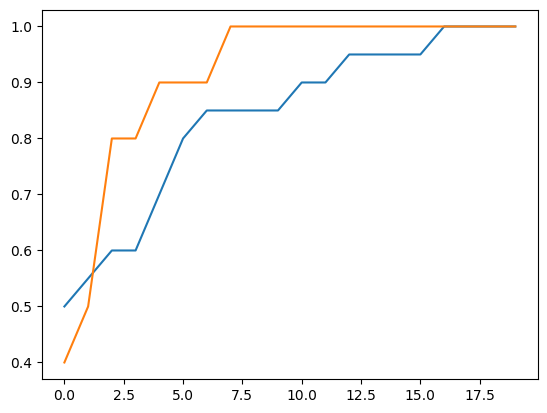

In [270]:
plt.plot(metric["acc"])
plt.plot(metric["val_acc"])
plt.show()

In [324]:
def nn_initializer(type, shape):
    b = np.sqrt(6.0/(shape[0] + shape[1]))
    return (np.random.rand(shape[0], shape[1]) - 0.5) * 2 * b

class LinearLayer(nnModule):
    def __init__(self, shape, init='xavier'):
        super().__init__()
        self.shape = shape # (o, i)
        self.w = nnParameter(val=nn_initializer('xavier', shape))
        self.b = nnParameter(val=np.zeros(shape[1]))
    def forward(self, x):
        #print(x.shape)
        #print(self.w.value().shape)
        return np.matmul(x, self.w.value()) + self.b.value()

class ActivationFn(nnModule):
    def __init__(self, type='tanh'):
        super().__init__()
        self.type = type
    def forward(self, x):
        return np.tanh(x)

class SoftMax(nnModule):
    def __init__(self):
        super().__init__()
    def forward(self, logits):
        x = np.exp(logits)
        return x/x.sum()

class Sequential(nnModule):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
    def forward(self, ins):
        cur = ins
        for layer in self.layers:
            #print(layer.shape)
            cur = layer.forward(cur)
        return cur

In [280]:
(np.matmul(np.random.rand(4, 3), np.random.rand(2, 3).transpose()) + np.array([10, 10]))

array([[11.25566122, 11.34251851],
       [10.19037337, 10.23194779],
       [11.4511318 , 11.18514511],
       [10.23887158, 10.31595489]])

In [282]:
c = np.random.rand(5)
c

array([0.99360781, 0.5378062 , 0.69587567, 0.87038012, 0.78741767])

In [287]:
d = np.exp(c)
d/d.sum()

0.9999999999999999

In [309]:
simple_nn.get_parameters()

{'layers.[0].w': <__main__.nnParameter at 0x4ee8320>,
 'layers.[0].b': <__main__.nnParameter at 0x45ad9a8>,
 'layers.[2].w': <__main__.nnParameter at 0x4effb68>,
 'layers.[2].b': <__main__.nnParameter at 0x4f08d78>,
 'layers.[4].w': <__main__.nnParameter at 0x459b808>,
 'layers.[4].b': <__main__.nnParameter at 0x4ecb0a0>}

In [298]:
ttt = np.random.randn(5, 2)
ttt

array([[-0.19156498,  1.20337073],
       [-0.54031015,  0.27813046],
       [ 1.79954953, -0.4581737 ],
       [-1.13629506, -1.21543726],
       [-1.0519437 ,  0.38517132]])

In [336]:
np.array((1, 2, 3)).prod()

6

In [340]:
simple_nn = Sequential([
    LinearLayer(shape=(2, 5)),
    ActivationFn(),
    LinearLayer(shape=(5, 4)),
    ActivationFn(),
    LinearLayer(shape=(4, 2)),
    SoftMax()
])

p_cnt = 0
for k, v in simple_nn.get_parameters().items():
    print("{k}: Shape {s}".format(k=k, s=v.val.shape))
    p_cnt += np.array(v.val.shape).prod()
print("Total param = {t}".format(t=p_cnt))

optimizer = OptimizerSGD(simple_nn.get_parameters(), {"lambda": 0.03})

data = np.random.randn(20, 2)
ans = np.sign(np.power(data[:, 0], 3) - data[:, 1])

data_validation = np.random.randn(10, 2)
ans_validation = np.sign(np.power(data_validation[:, 0], 3) - data_validation[:, 1])

class TestLoss(nnModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, ins, ans):
        return (- self.model.forward(ins)[:,0] * ans).sum()

#loss = SVMLoss(model_simple1)
loss = TestLoss(simple_nn)
#print("Initial accuracy: {a}".format(a=loss.accuracy(data, ans)))

metric = {"acc": [], "loss": [], "val_acc": []}

for i in range(20):
    loss.backward(data, ans)
    optimizer.steps()
    #print(test1.normal.val)
    #a=loss.accuracy(data, ans)
    l=loss.forward(data, ans)
    #v=loss.accuracy(data_validation, ans_validation)
    #metric["acc"].append(a)
    metric["loss"].append(l)
    #metric["val_acc"].append(v)
    v=0
    a=0
    print("Accuracy = {a}, Loss = {l}, validation acc = {v}".format(a=a, l=l, v=v))

layers.[0].w: Shape (2, 5)
layers.[0].b: Shape (5,)
layers.[2].w: Shape (5, 4)
layers.[2].b: Shape (4,)
layers.[4].w: Shape (4, 2)
layers.[4].b: Shape (2,)
Total param = 49
Accuracy = 0, Loss = 0.24803716001802428, validation acc = 0
Accuracy = 0, Loss = 0.23189470554300565, validation acc = 0
Accuracy = 0, Loss = 0.21606247895700353, validation acc = 0
Accuracy = 0, Loss = 0.20054583937117376, validation acc = 0
Accuracy = 0, Loss = 0.18534532629355702, validation acc = 0
Accuracy = 0, Loss = 0.17045700263917993, validation acc = 0
Accuracy = 0, Loss = 0.15587283138310642, validation acc = 0
Accuracy = 0, Loss = 0.1415810680497712, validation acc = 0
Accuracy = 0, Loss = 0.12756665424917393, validation acc = 0
Accuracy = 0, Loss = 0.11381160065021007, validation acc = 0
Accuracy = 0, Loss = 0.1002953508905001, validation acc = 0
Accuracy = 0, Loss = 0.08699512080225325, validation acc = 0
Accuracy = 0, Loss = 0.07388620989355311, validation acc = 0
Accuracy = 0, Loss = 0.0609422842267

In [304]:
np.sign(np.power(ttt[:, 0], 3) - ttt[:, 1])

array([-1., -1.,  1., -1., -1.])

In [341]:
gc.collect()

8